In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.ensemble import RandomForestClassifier 
from glob import glob,iglob
from osgeo import gdal , gdal_array
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from write_geotif import CreateGeoTiff
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.model_selection import FeatureImportances

from tqdm import tqdm
from joblib import Parallel, delayed
import earthpy.plot as ep
import gc
import os

import pickle4 as pickle



Data processing: to preprocess the data for some predictive modeling task, ensuring proper data types, handling categorical variables, and splitting the data into training and testing sets.

In [3]:
#Reading Data:This line reads a CSV file named "point_final.csv" into a pandas DataFrame (data_org) using pd.read_csv(). The delimiter used in the CSV file is ;.
data_org=pd.read_csv("point_final.csv",delimiter=";")

In [4]:
#Data Preprocessing:Here, a copy of the original DataFrame is created (data) to perform data preprocessing. In this step, commas in the data are replaced with periods. This is likely done to ensure consistency in representing decimal numbers.
data=data_org.copy()
data=data.replace(",",".",regex=True)

In [5]:
#Checking Data Types:This line prints out the data types of each column in the DataFrame data.
data.dtypes

OID_                  int64
Landslide             int64
LONGITUDE            object
LATITUDE             object
DTM_merged           object
slope                object
LULC                  int64
profile_curvature    object
plan_curvature       object
dist_acc_road        object
dist_river           object
NDVI                 object
rain                 object
aspect                int64
dtype: object

In [6]:
#Removing First Column:This line removes the first column from the DataFrame data. It's common in data processing tasks to remove index columns or columns that are not needed for analysis.
data=data.iloc[:,1:]

In [7]:
28905/100 

289.05

In [8]:
289.05*2

578.1

In [9]:
# Separate features and target variable: Here, the DataFrame X is created containing all the features (independent variables) except for the 'Landslide' column, while y contains only the 'Landslide' column, which is the target variable (dependent variable).
X=data.drop('Landslide', axis=1).copy()
y=data.loc[:,'Landslide'].copy()

In [10]:
X.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,LULC,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,aspect
0,91682.5802,92003.1689,373.0174866,0.787680209,4,-0.06276847,0.033129507,411.9653931,180.7027969,0.362031567,67.34322357,7
1,55682.266,104415.2486,385.8379517,16.82241821,2,-0.269385904,0.087632157,258.0426331,148.4890594,0.335763618,82.88248444,6
2,76261.6868,66915.8101,294.2075043,10.79049492,4,0.272305995,-0.318835378,580.9100647,373.3664398,0.4827781,71.41384125,8
3,56772.518,102116.9275,455.8366547,24.03018665,2,-0.174597126,0.955412209,539.9199219,80.76198578,0.265183495,82.81878662,8
4,67847.8478,81082.7308,315.7912445,2.850139856,4,0.11769855,0.001954662,138.8272247,569.63797,0.463345363,75.07782745,6


In [11]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Landslide, dtype: int64

In [12]:
#Converting Data Types:This line converts all the columns in DataFrame X to float data type.
X=X.astype(float)
X.dtypes

LONGITUDE            float64
LATITUDE             float64
DTM_merged           float64
slope                float64
LULC                 float64
profile_curvature    float64
plan_curvature       float64
dist_acc_road        float64
dist_river           float64
NDVI                 float64
rain                 float64
aspect               float64
dtype: object

In [13]:
#Converting Categorical Variables:Here, specific columns ('aspect' and 'LULC') are converted to string data type. This might be done in preparation for one-hot encoding categorical variables.
#!!!!!uncomment when you have your aspect as categorical/factor variable fro example 1,2,3,4.....
X['aspect']=X['aspect'].astype(str)
X['LULC']=X['LULC'].astype(str)

In [14]:
#Checking Data Types: This line prints out the data type of the target variable y.
y.dtypes

dtype('int64')

In [15]:
#Identifying Categorical Columns:This line identifies categorical columns in the DataFrame X and stores their column names in the list cols_obj.
cols_obj=X.columns[X.dtypes=='object'].values.tolist()
cols_obj
#One-Hot Encoding Categorical Variables: This line performs one-hot encoding on the categorical variables identified earlier and stores the result in the DataFrame X_encoded.
X_encoded=pd.get_dummies(X,columns=cols_obj)

#Train-Test Split:This line splits the data into training and testing sets using train_test_split() function from scikit-learn. The training set comprises 70% of the data, and stratification is applied based on the target variable y.
X_train, X_test, y_train, y_test=train_test_split(X_encoded,y, random_state=6768, train_size=0.70, stratify=y)



In [16]:
cols_obj

['LULC', 'aspect']

In [17]:
X_train.shape

(799, 26)

In [18]:
X_test.shape

(343, 26)

In [19]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

 XGBOOST: This code segment primarily focuses on training an XGBoost classifier, evaluating its performance, and optimizing its hyperparameters using grid search cross-validation. Let's break down the code step by step:
 Overall, this code trains an XGBoost classifier, evaluates its performance, visualizes the confusion matrix, and tunes its hyperparameters using grid search cross-validation to find the best combination of hyperparameters.

In [20]:
#Defining XGBoost Classifier:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=np.nan,eval_metric='aucpr', early_stopping_rounds=10,seed=42)
#Fitting the Classifier: This line trains the XGBoost classifier (clf_xgb) on the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])


[0]	validation_0-aucpr:0.85562
[1]	validation_0-aucpr:0.87215
[2]	validation_0-aucpr:0.86338
[3]	validation_0-aucpr:0.87025
[4]	validation_0-aucpr:0.89001
[5]	validation_0-aucpr:0.89830
[6]	validation_0-aucpr:0.89287
[7]	validation_0-aucpr:0.89529
[8]	validation_0-aucpr:0.89652
[9]	validation_0-aucpr:0.90158
[10]	validation_0-aucpr:0.90822
[11]	validation_0-aucpr:0.90658
[12]	validation_0-aucpr:0.90134
[13]	validation_0-aucpr:0.90312
[14]	validation_0-aucpr:0.90852
[15]	validation_0-aucpr:0.90706
[16]	validation_0-aucpr:0.90534
[17]	validation_0-aucpr:0.90504
[18]	validation_0-aucpr:0.90448
[19]	validation_0-aucpr:0.89736
[20]	validation_0-aucpr:0.89497
[21]	validation_0-aucpr:0.89505
[22]	validation_0-aucpr:0.89530
[23]	validation_0-aucpr:0.89439
[24]	validation_0-aucpr:0.89586


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
class_mapper={0:"Non-Landslide", 1:"Landslide"}

In [40]:
class_mapper.keys()

dict_keys([0, 1])

In [41]:
class_mapper.values()

dict_values(['Non-Landslide', 'Landslide'])

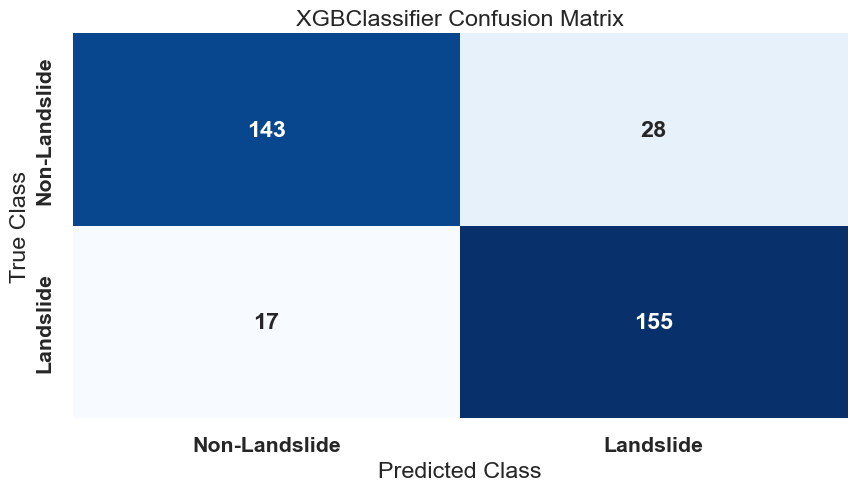

In [49]:
# Assuming you already have your predictions and true labels
y_pred = clf_xgb.predict(X_test)  # Get predictions
y_true = y_test  # True labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the labels
labels = ['Non-Landslide', 'Landslide']

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, ax=ax)

# Set the labels and title
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('XGBClassifier Confusion Matrix')

# Ensure the x-tick labels are horizontal (rotation=0)
plt.xticks(rotation=0)

# Save the confusion matrix plot
fig.savefig('./confusion_matrix1.png')

plt.show()


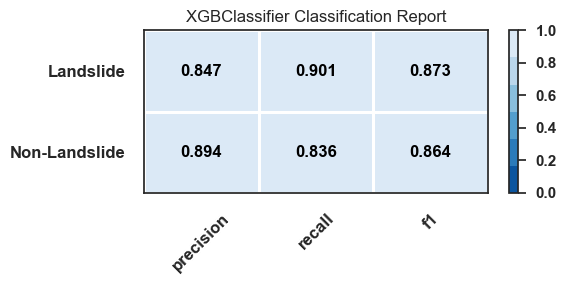

In [50]:
original_palette = sns.color_palette("Blues")

# Create a reversed version of the palette
reversed_palette = original_palette[::-1]

#Visualizing Classification Report: This line initializes a visualizer for generating a classification report. It provides a detailed summary of the model's performance, including precision, recall, F1-score, and support for each class
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)

#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. Additionally, it saves the visualization as an image file named "accuracy_assessment.png".
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(6,3))

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="./accuracy_assessment1.png")    
fig.tight_layout()



This code segment seems to perform several tasks after obtaining the optimal parameters through grid search cross-validation. Let's break down the steps:

In [26]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid={'max_depth':[3,4,5],
    'learning_rate':[0.1,0.05,0.01],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]}

In [27]:
#Grid Search Cross-Validation:An instance of GridSearchCV (optimal_params) is created with the XGBoost classifier as the estimator, the specified parameter grid, and other settings like verbosity, number of parallel jobs, and cross-validation folds.
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42,subsample=0.9,eval_metric='aucpr',early_stopping_rounds=10),
                           param_grid=param_grid,verbose=2,n_jobs=16,cv=5)

In [28]:
#Fitting the Grid Search:The fit method is called on optimal_params to perform the grid search cross-validation on the training data. The evaluation is done on the test set as well.
optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-aucpr:0.75383
[1]	validation_0-aucpr:0.75165
[2]	validation_0-aucpr:0.78445
[3]	validation_0-aucpr:0.78455
[4]	validation_0-aucpr:0.78820
[5]	validation_0-aucpr:0.78440
[6]	validation_0-aucpr:0.78089
[7]	validation_0-aucpr:0.81208
[8]	validation_0-aucpr:0.83142
[9]	validation_0-aucpr:0.84371
[10]	validation_0-aucpr:0.84680
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85354
[13]	validation_0-aucpr:0.86112
[14]	validation_0-aucpr:0.86464
[15]	validation_0-aucpr:0.87318
[16]	validation_0-aucpr:0.88551
[17]	validation_0-aucpr:0.88494
[18]	validation_0-aucpr:0.88591
[19]	validation_0-aucpr:0.88622
[20]	validation_0-aucpr:0.88622
[21]	validation_0-aucpr:0.88749
[22]	validation_0-aucpr:0.88948
[23]	validation_0-aucpr:0.88596
[24]	validation_0-aucpr:0.88820
[25]	validation_0-aucpr:0.88467
[26]	validation_0-aucpr:0.88292
[27]	validation_0-aucpr:0.88292
[28]	validation_0-aucpr:0.89115
[29]	validation_0-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=16,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             verbose=2)

In [29]:
#Best Parameters:This line prints out the best parameters found by the grid search cross-validation.
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

In [30]:
#Setting up XGBoost Classifier with Optimal Parameters: Here, an instance of the XGBoost classifier (clf_xgb) is created with the optimal parameters obtained from grid search cross-validation. Additionally, other settings such as the objective function, seed, and subsample are specified.
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=0,eval_metric='aucpr', early_stopping_rounds=10,seed=52366545,
                          **optimal_params.best_params_,subsample=0.9)

In [31]:
#Fitting the Classifier and Training Set:This line fits the XGBoost classifier to the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.78490
[1]	validation_0-aucpr:0.80626
[2]	validation_0-aucpr:0.80824
[3]	validation_0-aucpr:0.81635
[4]	validation_0-aucpr:0.81817
[5]	validation_0-aucpr:0.81184
[6]	validation_0-aucpr:0.86134
[7]	validation_0-aucpr:0.86635
[8]	validation_0-aucpr:0.87161
[9]	validation_0-aucpr:0.86795
[10]	validation_0-aucpr:0.86281
[11]	validation_0-aucpr:0.86695
[12]	validation_0-aucpr:0.86759
[13]	validation_0-aucpr:0.87321
[14]	validation_0-aucpr:0.87926
[15]	validation_0-aucpr:0.87658
[16]	validation_0-aucpr:0.87511
[17]	validation_0-aucpr:0.88000
[18]	validation_0-aucpr:0.88329
[19]	validation_0-aucpr:0.89093
[20]	validation_0-aucpr:0.88959
[21]	validation_0-aucpr:0.89129
[22]	validation_0-aucpr:0.88935
[23]	validation_0-aucpr:0.88955
[24]	validation_0-aucpr:0.88774
[25]	validation_0-aucpr:0.89997
[26]	validation_0-aucpr:0.90220
[27]	validation_0-aucpr:0.89977
[28]	validation_0-aucpr:0.89888
[29]	validation_0-aucpr:0.89821
[30]	validation_0-aucpr:0.90348
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
X_train

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
321,49848.0878,100267.0885,404.632416,16.809582,0.135305,-0.005950,66.925327,97.977036,0.331368,84.384460,...,False,False,False,False,False,True,False,False,False,False
1115,89695.0000,90019.0000,353.415008,17.768637,-0.632733,-0.768533,70.000000,594.229767,0.450290,67.041664,...,False,False,False,False,False,True,False,False,False,False
376,82078.0651,98264.6255,306.773453,2.824122,0.013427,0.054874,30.805843,83.297642,0.501121,69.443787,...,False,False,False,True,False,False,False,False,False,False
624,56854.4194,65176.4916,400.808990,2.743535,-0.021748,-0.114540,147.492371,601.791504,0.408595,81.559036,...,False,False,True,False,False,False,False,False,False,False
575,77413.7941,81349.4616,230.217537,3.446514,0.026919,-0.146082,159.050308,245.718338,0.351439,69.168785,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,81659.0355,90147.9564,304.052490,12.033729,-0.091309,0.003311,139.846344,78.924011,0.413930,69.559464,...,False,False,False,False,False,True,False,False,False,False
1076,92989.0000,63595.0000,229.800003,19.388506,0.417075,0.466161,421.921783,258.052322,0.487769,65.642372,...,False,False,False,False,False,False,False,False,True,False
796,75383.1660,89034.8312,309.070007,1.294650,-0.069368,0.001527,444.342224,248.471329,0.319260,68.575142,...,False,False,True,False,False,False,False,False,False,False
1048,79765.0000,101829.0000,241.242897,8.725870,1.713025,-0.086424,74.632431,62.209316,0.460003,68.849998,...,False,False,False,True,False,False,False,False,False,False


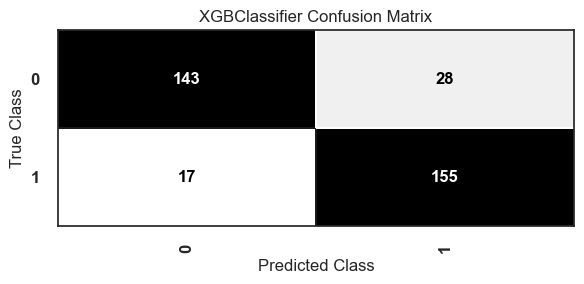

In [36]:
#Visualizing Confusion Matrix:This section visualizes the confusion matrix of the trained model using the ConfusionMatrix visualizer. It helps in understanding the model's performance in terms of true positive, true negative, false positive, and false negative predictions.
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()))
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()),cmap="Greys")
fig,ax=plt.subplots(figsize=(6,3))
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()
# Save the visualization as an image file
fig.savefig('F:/thesis/confusion_matrix.png')

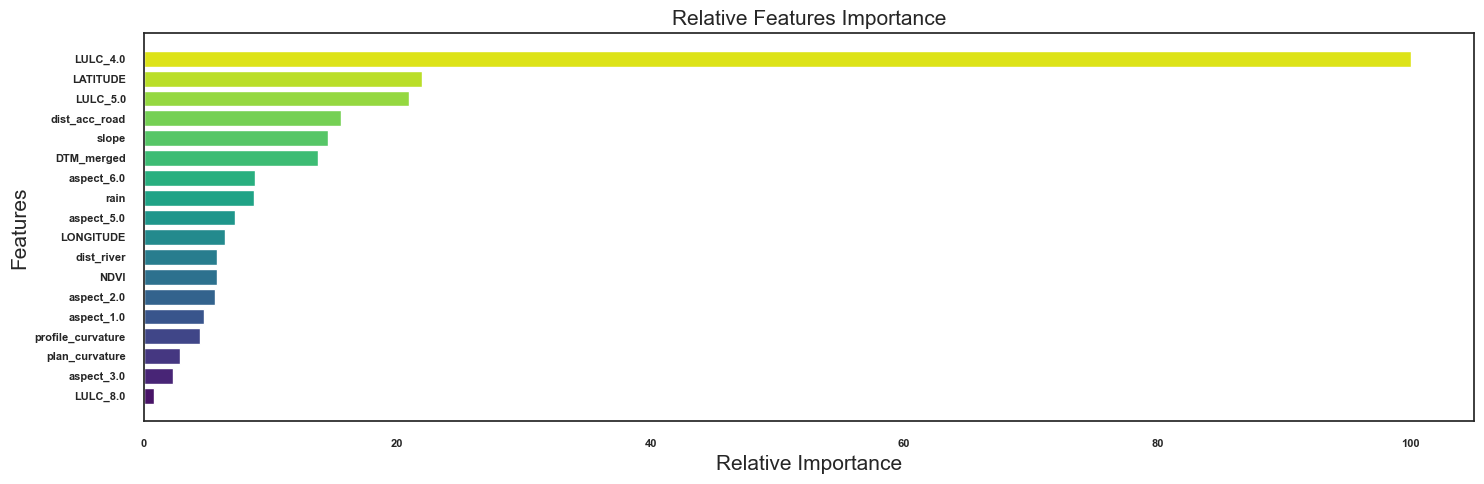

In [38]:
#Visualizing Feature Importances:Here, the code visualizes the relative importance of features in predicting the target variable using the FeatureImportances visualizer. This helps in understanding which features are more influential in the model's predictions
# Assuming clf_rf is already defined and trained
names = clf_xgb.feature_names_in_
importance_normalized = (clf_xgb.feature_importances_ / max(clf_xgb.feature_importances_)) * 100
values = importance_normalized

# Filter out features with 0 importance
importance_dic_filtered = {k: v for k, v in zip(names, values) if v > 0}
sort_id = sorted(importance_dic_filtered, key=lambda x: importance_dic_filtered[x], reverse=False)
importance_dic_filtered_sorted = {k: importance_dic_filtered[k] for k in sort_id}

# Generate a nice color palette using seaborn
num_colors = len(sort_id)
colours = sns.color_palette("viridis", num_colors)

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(list(importance_dic_filtered_sorted.keys()), list(importance_dic_filtered_sorted.values()), color=colours)

# Make font size bigger
ax.set_title("Relative Features Importance", fontsize=15)
ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Relative Importance", fontsize=15)

# Set font size for tick labels
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()
fig.savefig('F:/thesis/relative_features.png')

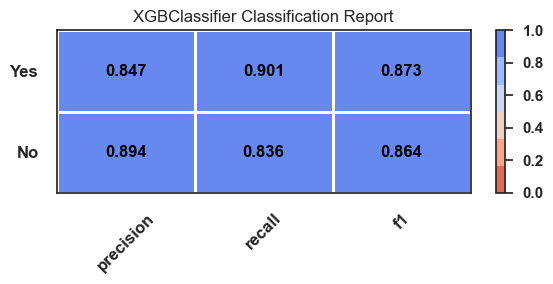

In [35]:
#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. Additionally, it saves the visualization as an image file named "accuracy_assessment.png".

# Define the new color palette
original_palette = sns.color_palette("coolwarm")

# Create a reversed version of the palette
reversed_palette = original_palette[::-1]

# Initialize the ClassificationReport visualizer with the new reversed palette
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False, cmap=reversed_palette)

# Set Seaborn style and font
sns.set(style="white", font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Fit and score the visualizer
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data

# Show and save the visualization
visualizer.show(outpath="./accuracy_assessment1.png")

# Adjust the layout
fig.tight_layout()


Overall, this code segment aims to provide a comprehensive assessment of the XGBoost classifier's performance, including visualizations of feature importances, confusion matrix, and a detailed classification report.

## prediction for the entire image 

This code segment is aimed at making predictions for an entire image using the trained XGBoost classifier and then saving the predicted probabilities as a GeoTIFF file. Let's break down the steps:

In [37]:
#Loading Image Files:
full_data_files=glob("F:/thesis/TEMP/project/data/*.tif")

In [38]:
full_data_files

['F:/thesis/TEMP/project/data\\aspect_clip.tif',
 'F:/thesis/TEMP/project/data\\clip_dtm.tif',
 'F:/thesis/TEMP/project/data\\dist_riv_mask.tif',
 'F:/thesis/TEMP/project/data\\DTM_merged_crop1.tif',
 'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
 'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
 'F:/thesis/TEMP/project/data\\ndvi_rescale11.tif',
 'F:/thesis/TEMP/project/data\\plan_curvature.tif',
 'F:/thesis/TEMP/project/data\\plan_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\profile_curvature.tif',
 'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip11.tif',
 'F:/thesis/TEMP/project/data\\rain_resample11.tif',
 'F:/thesis/TEMP/project/data\\reclass_aspect111.tif',
 'F:/thesis/TEMP/project/data\\resample_lulc11.tif',
 'F:/thesis/TEMP/project/data\\river_clip.tif',
 'F:/thesis/TEMP/project/data\\road_clip.tif',
 'F:/thesis/TEMP/project/data\\road_resample.tif',
 'F:/thesis/TEMP/project/data\\slope1_cl

In [39]:
files_sorted=['F:/thesis/TEMP/project/data\\clip_dtm.tif',
            'F:/thesis/TEMP/project/data\\slope1_clip.tif',
             'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
             'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
             'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
             'F:/thesis/TEMP/project/data\\road_clip.tif',
             'F:/thesis/TEMP/project/data\\river_clip.tif',
             'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
            'F:/thesis/TEMP/project/data\\rain_clip11.tif',
             'F:/thesis/TEMP/project/data\\aspect_clip.tif']

In [40]:
"""
files_sorted = ['./data/dist_riv_mask.tif',
                './data/DTM_merged_crop1.tif',
                './data/ndvi_rescale.tif',
                './data/plan_curvature.tif',
                './data/profile_curvature.tif',
                './data/rain_resample.tif',
                './data/reclass_aspect111.tif',
                './data/resample_lulc.tif',
                './data/road_resample.tif',
                './data/slope_resample.tif']
"""

"\nfiles_sorted = ['./data/dist_riv_mask.tif',\n                './data/DTM_merged_crop1.tif',\n                './data/ndvi_rescale.tif',\n                './data/plan_curvature.tif',\n                './data/profile_curvature.tif',\n                './data/rain_resample.tif',\n                './data/reclass_aspect111.tif',\n                './data/resample_lulc.tif',\n                './data/road_resample.tif',\n                './data/slope_resample.tif']\n"

In [41]:
X_encoded.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
0,91682.5802,92003.1689,373.017487,0.787680,-0.062768,0.033130,411.965393,180.702797,0.362032,67.343224,...,False,False,False,False,False,False,False,True,False,False
1,55682.2660,104415.2486,385.837952,16.822418,-0.269386,0.087632,258.042633,148.489059,0.335764,82.882484,...,False,False,False,False,False,False,True,False,False,False
2,76261.6868,66915.8101,294.207504,10.790495,0.272306,-0.318835,580.910065,373.366440,0.482778,71.413841,...,False,False,False,False,False,False,False,False,True,False
3,56772.5180,102116.9275,455.836655,24.030187,-0.174597,0.955412,539.919922,80.761986,0.265183,82.818787,...,False,False,False,False,False,False,False,False,True,False
4,67847.8478,81082.7308,315.791245,2.850140,0.117699,0.001955,138.827225,569.637970,0.463345,75.077827,...,False,False,False,False,False,False,True,False,False,False


In [42]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [43]:
"""
#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.
full_data_array=[]
subset=(0,0, 6860,4064)
for i in files_sorted:
    full_data_array.append(gdal.Open(i).ReadAsArray(*subset))
"""

'\n#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.\nfull_data_array=[]\nsubset=(0,0, 6860,4064)\nfor i in files_sorted:\n    full_data_array.append(gdal.Open(i).ReadAsArray(*subset))\n'

In [44]:
def offset_chunk_dimension(arrayshape=None, chunk_size=None):
    xy_chunk=chunk_size
    if len(arrayshape)==2:
        array_shape=(0,arrayshape[0], arrayshape[1])
    x_blocks=np.ceil(array_shape[-2]/xy_chunk[0]).astype(int)
    y_blocks=np.ceil(array_shape[-1]/xy_chunk[1]).astype(int)
    x_offsets=np.arange(x_blocks,dtype=int) *xy_chunk[0]
    y_offsets=np.arange(y_blocks,dtype=int) *xy_chunk[1]
    grid_offset=np.meshgrid(x_offsets,y_offsets)
    xy_offsets=np.c_[grid_offset[0].ravel(),grid_offset[1].ravel()]
    x_chunk=(np.repeat(xy_chunk[0],x_blocks).astype(int))
    rmd_x=array_shape[1]%xy_chunk[0]
    if rmd_x>0:
        x_chunk[-1]=rmd_x
    y_chunk=(np.repeat(xy_chunk[1],y_blocks).astype(int))
    rmd_y=array_shape[2]%xy_chunk[1]
    if rmd_y>0:
        y_chunk[-1]=rmd_y
    grid_chunk=np.meshgrid(x_chunk,y_chunk)
    xy_grid_chunk=np.c_[grid_chunk[0].ravel(),grid_chunk[1].ravel()]
    xy_grid_chunk=xy_grid_chunk.tolist()
    return np.hstack([xy_offsets,xy_grid_chunk])

In [45]:
def write_out_blk(idx=1,im_array=None,xoffset=None,yoffset=None, NDV=-9999, band_name="xgboost"):  
    DataSet.GetRasterBand(idx).WriteArray(im_array,xoff=xoffset,yoff=yoffset)
    DataSet.GetRasterBand(idx).SetNoDataValue(NDV)
    DataSet.SetDescription(band_name)

In [59]:
data_template=gdal.Open(files_sorted[2])
band=data_template.GetRasterBand(1)

In [60]:
Name="./xgboost/xgboost_pred.tif"
DataType=6
driver= gdal.GetDriverByName('GTIFF')
#Array[np.isnan(Array)] = NDV
DataSet = driver.Create(Name, band.XSize, band.YSize, DataType)
DataSet.SetGeoTransform(data_template.GetGeoTransform())
DataSet.SetProjection(data_template.GetProjection())
fname=os.path.basename(Name)

In [61]:
blocks=offset_chunk_dimension(arrayshape=(band.XSize,band.YSize), chunk_size=(400,400))

In [62]:
blocks=blocks.tolist()

In [63]:
blocks[:3]

[[0, 0, 400, 400], [400, 0, 400, 400], [800, 0, 400, 400]]

In [64]:
# k1=[geotransform_x + (i*x_pixel) for i in range(blocks[1][0],blocks[1][0]+blocks[1][2])]
# k2=[ geotransform_y + (i*y_pixel) for i in range (blocks[1][1], blocks[1][1]+blocks[1][3]) ]

In [65]:
geot=gdal.Open(files_sorted[0]).GetGeoTransform()

In [66]:
import pickle

In [67]:
clf_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'aucpr',
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': 0,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

In [68]:
model_parameters="./xgb_boost_finalized_model.sav"

In [69]:
with open(model_parameters, "wb") as file:
    pickle.dump(clf_xgb.get_xgb_params(),file)

In [70]:

with open("./xgb_boost_finalized_model.sav", 'rb') as file:
    
    optimal_parameters=pickle.load(file) 



# Defining XGBoost Classifier:
xgb.XGBClassifier(**optimal_parameters)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
optimal_parameters

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': 'aucpr',
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

In [74]:
#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.
block_id=1
#hard_encoded:composite_block_array.columns,X_encoded.columns,clf_xgb, filename
def predict_model_blocks(sorted_image_list=files_sorted, block=None, geotransform=None):
    subset=block
    
    #Creating Longitude and Latitude Arrays: Longitude and latitude arrays are generated based on the geotransform information obtained from one of the TIFF files
    geotransform_x=geotransform[0]
    geotransform_y=geotransform[3]
    x_pixel=geotransform[1]
    y_pixel=geotransform[5]
    long=[geotransform_x + (i*x_pixel) for i in range(block[0],block[0]+block[2])]
    lat=[ geotransform_y + (i*y_pixel) for i in range (block[1], block[1]+block[3]) ]
    
    xx,yy=np.meshgrid(np.array(long),np.array(lat))
    xx_yy_matrix=np.c_[xx.ravel(), yy.ravel()]
    
    composite_block_array=[gdal.Open(i).ReadAsArray(*subset) for i in sorted_image_list]
    
    composite_block_array=np.stack(composite_block_array)
    dimension=composite_block_array.shape
    
    #Reshaping Image Data:The 3D array is reshaped into a 2D array for further processing.
    composite_block_array=composite_block_array.reshape(dimension[0],(dimension[1]*dimension[2]))
    composite_block_array=composite_block_array.swapaxes(0,1)
    
    #Concatenating Longitude, Latitude, and Image Data:Longitude, latitude, and image data arrays are concatenated horizontally to form a single array representing the entire dataset.
    composite_block_array=np.hstack((xx_yy_matrix,composite_block_array))
    composite_block_array=pd.DataFrame(composite_block_array, columns=X.columns)
    
    composite_block_array['aspect']=composite_block_array['aspect'].astype(str)
    composite_block_array['LULC']=composite_block_array['LULC'].astype(str)
    cols_obj_full=composite_block_array.columns[composite_block_array.dtypes=='object'].values.tolist()
    #encoded
    composite_block_array=pd.get_dummies(composite_block_array,columns=cols_obj_full)
    
    # Assuming X_encoded and full_data_array_df_encoded are your DataFrames
    missing_columns = [c for c in X_encoded.columns if c not in composite_block_array.columns]
    
    # Add missing columns to full_data_array_df_encoded and fill with false
    if  len(missing_columns)>0:
       composite_block_array[missing_columns] = False
    
    #Columns in the DataFrame are filtered to match those used during training, and their order is rearranged accordingly.
    composite_block_array=composite_block_array[X_encoded.columns]
    
    # Making predictions using the XGBoost model
    #predictions = clf_xgb.predict(composite_block_array)
    predictions = clf_xgb.predict_proba(composite_block_array)
    #probability of occurence 
    predictions=predictions[:,1]
    
    #Reshaping Predictions:The predicted probabilities are reshaped to match the dimensions of the original image.
    predictions=predictions.reshape(dimension[1:])
    
    write_out_blk(idx=1,im_array= predictions,xoffset=subset[0],yoffset=subset[1], NDV=-9999, band_name="xgboost")
    return block
    
